In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'Validated_Hack_Cases_V1_v2'#'Validated_Hack_Cases_V1'#'Validated'
DATA_FOLDER_PATTERN ='t1'#'DataSet0'#'p1'#'b2'#'t1' # 'DataSet0' #'t1'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

lCsvColName     = ['Transaction ID', 'Block Time', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash', 'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used', 'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level']
lCsvColNameFlag = [True,              True,         True,               True,        True,          True,            True,     True,       True,            True,            True,           True,        True,        True,       True,            True,         True,          False,   False]  #<! Flags if a column is a must to have

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
dfData, dAssetFile =  LoadCsvFilesDf(lCsvFile, baseFoldePath = '', lColName = lCsvColName, lColFlag =  lCsvColNameFlag ,  addFileNameCol = True)

numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 1
The number of rows (Samples): 86, The number of columns: 20, number of unique sender id's: (1,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'File Name'],
      dtype='object') with 20 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level,File Name
85,0x631fa19e55f2c07e4b01b05377b917c972dbc1db752d...,NaN,2022-10-06 16:16:59+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,11.648835,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,118.345120,1.920000e-08,279912,270237,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
84,0x7f9d7746290174e3d67a000f5bf8e228b9c843665ebc...,NaN,2022-10-06 16:30:35+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,4.923662,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,50.021426,1.470000e-08,262812,253137,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
83,0xa5d4f1a63a051158eb4f7aa451f926536b6d8a5d8c99...,NaN,2022-10-06 16:48:11+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,353.000000,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,3586.266619,6.080000e-08,211500,206625,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
82,0x97f60b4d6a1bec5482f5f0f78d3c187b284de6b2f649...,NaN,2022-10-06 16:50:11+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,152.295165,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,1547.226816,7.840000e-08,211512,201837,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
81,0x7635c21833c67e358820a5224d9d47186d3566729cd0...,NaN,2022-10-06 21:32:59+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,254.243107,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,2582.956280,9.320000e-09,211500,201825,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
80,0x2e91e6052dacc16db180907c945fad4a78b0c1881e7a...,NaN,2022-10-07 02:30:47+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,5.310000,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,53.990222,9.650000e-09,211500,206625,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
79,0xf0d7a3333e6d0b4d5739b7996d2890daca368c4efae4...,NaN,2022-10-07 02:35:59+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,340.000000,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,3457.001042,1.010000e-08,211500,206625,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
78,0x205b784122ad71055fb4c64a1d46fec6b8fa88fc3147...,NaN,2022-10-07 03:23:35+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,351.820149,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,3577.184176,5.830000e-09,211512,206637,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
77,0xe7cd005a7450246e6401ae160bc5ccbe01dda1e3a071...,NaN,2022-10-07 04:13:11+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,276.574270,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,2812.110406,5.450000e-09,210836,201161,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv
76,0x253f88d006ee24e48c8c60014bd49cab2b972a93294b...,NaN,2022-10-07 08:23:11+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0x245cc372c84b3645bf0ffe6538620b04a217988b,NaN,6.132447,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,62.352572,5.960000e-09,211512,206637,NaN,NaN,NaN,0,NaN,test_Olympus_Hack.csv


# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [10]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level,File Name
5,0x3ed75df83d907412af874b7998d911fdf990704da87c...,NaN,2022-10-21 05:22:47+00:00,0x007fe7c498a2cf30971ad8f2cbc36bd14ac51156,0xa29e4fe451ccfa5e7def35188919ad7077a4de8f,NaN,30437.07795,OHM,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,erc20,304906.4768,3.720000e-08,391230,64853,NaN,NaN,NaN,1,NaN,test_Olympus_Hack.csv


In [11]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    85
1     1
Name: Label, dtype: int64

In [12]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

1

In [13]:
dfData['Label'].value_counts()

0    85
1     1
Name: Label, dtype: int64

In [14]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 85 to 0
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Transaction ID    86 non-null     object             
 1   Transaction Time  0 non-null      float64            
 2   Block Time        86 non-null     datetime64[ns, UTC]
 3   Sender ID         86 non-null     object             
 4   Receiver ID       86 non-null     object             
 5   Receiver Type     0 non-null      float64            
 6   Amount            86 non-null     float64            
 7   Currency          86 non-null     object             
 8   Currency Hash     86 non-null     object             
 9   Currency Type     86 non-null     object             
 10  Amount [USD]      84 non-null     float64            
 11  Gas Price         86 non-null     float64            
 12  Gas Limit         86 non-null     int64              
 13  Gas Use

In [15]:
dfData.describe()

,Transaction Time,Receiver Type,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,0.0,86.000000,84.000000,8.600000e+01,86.00000,86.000000,0.0,0.0,0.0,86.000000,0.0
mean,NaN,NaN,658.675972,6810.973995,2.680221e-08,197263.72093,182429.616279,NaN,NaN,NaN,0.011628,NaN
std,NaN,NaN,3268.255191,33112.336168,1.494569e-08,68721.32098,55426.619512,NaN,NaN,NaN,0.107833,NaN
min,NaN,NaN,0.000000,7.167412,4.650000e-09,65294.00000,41879.000000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,5.020246,60.261985,1.787500e-08,194400.00000,189525.000000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,326.000000,3405.218132,2.415000e-08,210320.50000,201831.000000,NaN,NaN,NaN,0.000000,NaN
75%,NaN,NaN,353.750000,3669.770562,3.390000e-08,211677.00000,206637.000000,NaN,NaN,NaN,0.000000,NaN
max,NaN,NaN,30437.077950,304906.476800,7.840000e-08,578318.00000,270237.000000,NaN,NaN,NaN,1.000000,NaN


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [16]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 2


In [17]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [18]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [19]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [20]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 84, The number of columns: 20


# Meet the Data

Basic infomration about the data.

In [21]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 85 to 2
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Transaction ID    84 non-null     object             
 1   Transaction Time  0 non-null      float64            
 2   Block Time        84 non-null     datetime64[ns, UTC]
 3   Sender ID         84 non-null     object             
 4   Receiver ID       84 non-null     object             
 5   Receiver Type     0 non-null      float64            
 6   Amount            84 non-null     float64            
 7   Currency          84 non-null     object             
 8   Currency Hash     84 non-null     object             
 9   Currency Type     84 non-null     object             
 10  Amount [USD]      84 non-null     float64            
 11  Gas Price         84 non-null     float64            
 12  Gas Limit         84 non-null     int64              
 13  Gas Use

In [22]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Receiver Type,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,0.0,84.000000,84.000000,8.400000e+01,84.000000,84.000000,0.0,0.0,0.0,84.000000,0.0
mean,NaN,NaN,674.358734,6810.973995,2.689631e-08,200155.654762,185690.761905,NaN,NaN,NaN,0.011905,NaN
std,NaN,NaN,3305.778897,33112.336168,1.511170e-08,66871.521381,51797.778536,NaN,NaN,NaN,0.109109,NaN
min,NaN,NaN,0.690000,7.167412,4.650000e-09,65294.000000,55504.000000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,5.926835,60.261985,1.760000e-08,194400.000000,189525.000000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,331.000000,3405.218132,2.420000e-08,211150.000000,201837.000000,NaN,NaN,NaN,0.000000,NaN
75%,NaN,NaN,354.250000,3669.770562,3.425000e-08,211683.000000,206637.000000,NaN,NaN,NaN,0.000000,NaN
max,NaN,NaN,30437.077950,304906.476800,7.840000e-08,578318.000000,270237.000000,NaN,NaN,NaN,1.000000,NaN


In [23]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

### SASA vs. SAMA Cases

Definitions:

 * SASA:
 * SAMA:

**Remark**: Move to:

SASASW - Single Asset, Single   Attacks, Single   Wallets  
SAMASW - Single Asset, Multiple Attacks, Single   Wallets (SAMA)  
SAMAMW - Single Asset, Multiple Attacks, Multiple Wallets (SAMA)  

In [24]:
# Analysis of Attack Type
# !!! The function `CalcAttackType()` uses the Pandas extension, hence it should be initialized before!
dsAttackType, dfAttackType = CalcAttackType(dfData)

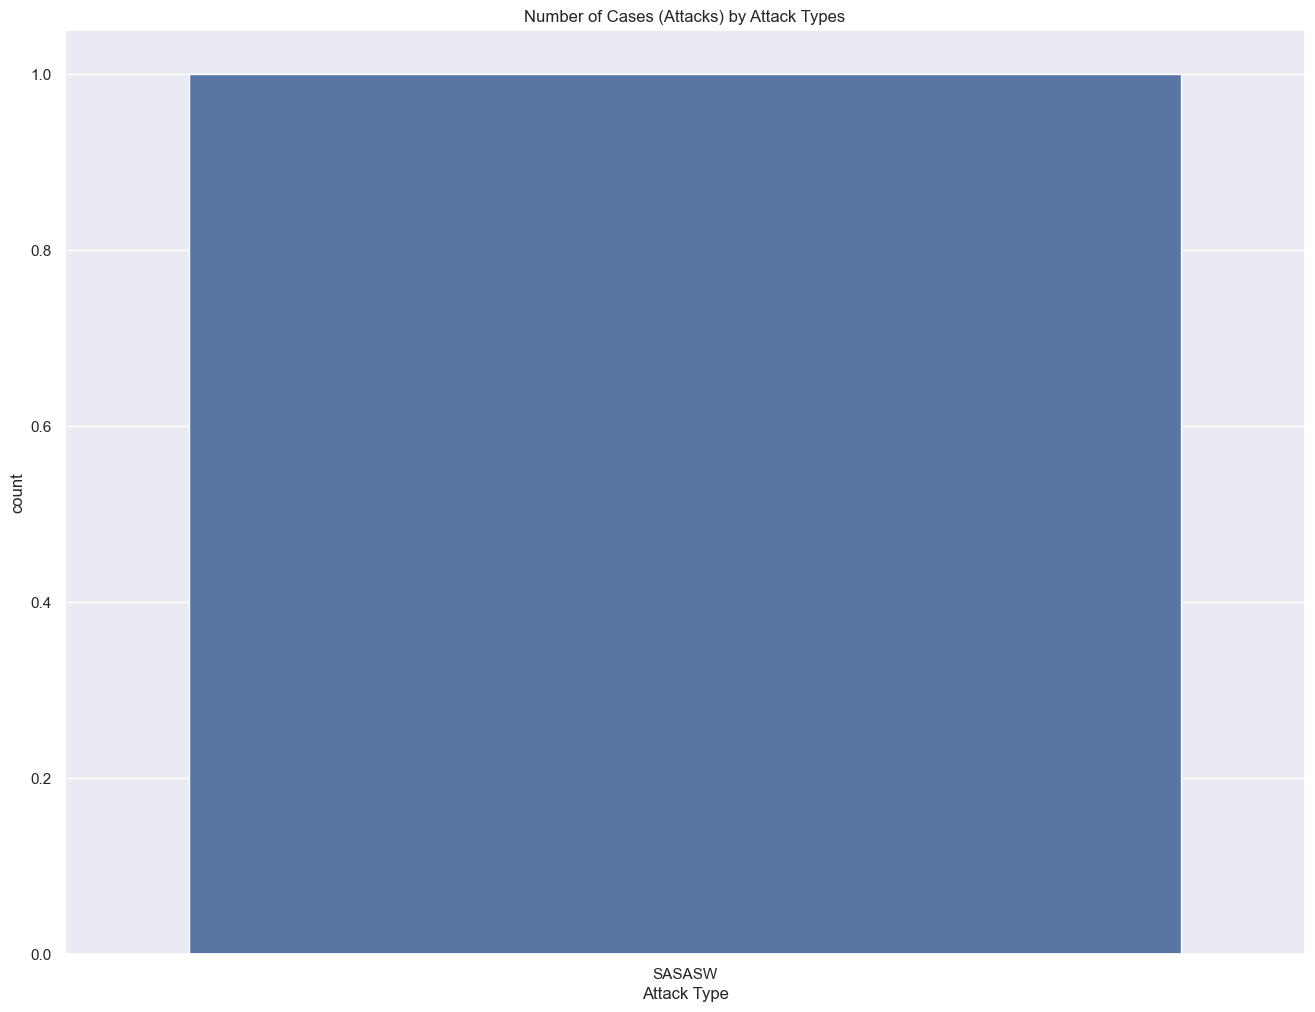

In [25]:
# Display an Histogram of the Attack Types
hF, hA = plt.subplots(figsize = (16, 12))
sns.countplot(x = dfAttackType['Attack Type'], ax = hA)
hA.set_title('Number of Cases (Attacks) by Attack Types')
plt.show()

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [26]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [27]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [28]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [29]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [30]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [31]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [32]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [33]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [34]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [35]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [36]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


## Features Visualization

## Features Pre Processing (For Training Phase)

In [37]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

### K-fold training, using categorical variables (EXPERIMENT)

In [38]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [ ]:
'''
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])
'''

In [39]:
########### load saved scalers:
import pickle
with open('scaler_.pkl', 'rb') as f:
    scaler_dct = pickle.load(f)

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)

 
for f in lNumericalFeatures:
    hStdScaler = scaler_dct[f]
    dfX_[f] = hStdScaler.transform(dfX_[[f]])
    


In [ ]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)

scaler_dct = {}
for f in lNumericalFeatures:
    hStdScaler = StandardScaler()
    hStdScaler = hStdScaler.fit(dfX_[[f]]) 
    dfX_[f] = hStdScaler.transform(dfX_[[f]])
    #dfX_[f] = hStdScaler.fit_transform(dfX_[[f]])
    scaler_dct[f] = hStdScaler


In [40]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


In [ ]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData_['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [ ]:
models = []
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData_['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    models.append([vTrainIdx, vTestIdx, xgbModel])

In [ ]:
#dfData_.iloc[models[0][0]]['File Name'].unique().shape
#dfData_['File Name'].unique().shape

#vTrainIdx = fns_['FakeHeroTokenSale005.csv']#fns[i]
#file_name = dfData_.iloc[vTrainIdx]['File Name'].unique()
#mXTrain, vYTrain = mX.iloc[vTrainIdx], vY.iloc[vTrainIdx]
#vYPred = model.predict(mXTrain)
#cm = confusion_matrix(vYTrain, vYPred, labels = model.classes_)
#cm


In [ ]:
dfData_.iloc[vTrainIdx_]['File Name'].unique().shape

In [ ]:
vTrainIdx_ = models[-1][0]
vTestIdx_  = models[-1][1]
model      = models[-1][-1]

In [ ]:
fns = {}
for i in vTrainIdx_:
    fn = dfData_.iloc[i]['File Name']
    if fn not in fns:
        fns[fn] = [i]
    else:
        fns[fn].append(i)    

In [ ]:
 
fns_ = {}
for i in vTestIdx_:
    fn = dfData_.iloc[i]['File Name']
    if fn not in fns_:
        fns_[fn] = [i]
    else:
        fns_[fn].append(i)    

In [ ]:

#vTrainIdx_ = models[-1][0]
#vTestIdx_ = models[-1][1]
#model = models[-1][-1]

r = []

for i in fns:
    vTrainIdx = fns[i]
    file_name = dfData_.iloc[vTrainIdx]['File Name'].unique()
    #print(file_name , i)
    mXTrain, vYTrain = mX.iloc[vTrainIdx], vY.iloc[vTrainIdx]
    vYPred = model.predict(mXTrain)
    #print(confusion_matrix(vYTrain, vYPred, labels = model.classes_))
    tn, fp, fn, tp = confusion_matrix(vYTrain, vYPred, labels = model.classes_).ravel()#cm = confusion_matrix(vYTrain, vYPred, labels = model.classes_)
    #print(cm[0][0] , cm[0][1], cm[1][0],cm[1][1], 'train set', file_name)
    r.append((tn, fp, fn, tp, 'train set', file_name[0]))


In [ ]:
len(r)

In [ ]:
for i in fns_:
    vTrainIdx = fns_[i]
    file_name = dfData_.iloc[vTrainIdx]['File Name'].unique()
    mXTrain, vYTrain = mX.iloc[vTrainIdx], vY.iloc[vTrainIdx]
    vYPred = model.predict(mXTrain)
    tn, fp, fn, tp = confusion_matrix(vYTrain, vYPred, labels = model.classes_).ravel()#cm = confusion_matrix(vYTrain, vYPred, labels = model.classes_)
    r.append((tn, fp, fn, tp, 'test set', file_name[0]))


In [ ]:
import pandas as pd
 
data = r# [['Geeks', 10], ['for', 15], ['geeks', 20]]
df = pd.DataFrame(data, columns = ['true_negative' , 'false_positive', 'false_negative', 'true_positive', 'train set', 'file_name'])
 
# print dataframe.
#df.to_csv('v1_rep.csv')

In [ ]:
'''
vTrainIdx_ = models[-1][0]
vTestIdx_ = models[-1][1]
model = models[-1][-1]

for vTrainIdx in vTrainIdx_:
    file_name = dfData_.iloc[vTrainIdx]['File Name'].unique()
    print(file_name)
    mXTrain, vYTrain = mX.iloc[vTrainIdx], vY.iloc[vTrainIdx]
    vYPred = model.predict(mXTrain)
    print(confusion_matrix(vYTrain, vYPred, labels = model.classes_))
'''


In [ ]:
dd = pd.read_csv('v1_at.csv' , index_col=False)
dd = dd.reset_index(drop=True)
dd['File Name'] = dd['File Name'] + '.csv'	
	
dat = dd.set_index('File Name').to_dict()['Attack Type']  
dat

In [ ]:
df['Attack_Type'] =  df.apply(lambda x: dat[x['file_name']] if x['file_name'] in dat else 'not found',axis=1)

In [ ]:
df.to_csv('v1_rep.csv')

In [ ]:
#vTrainIdx_
models[-1]

In [ ]:
#dfData_.iloc[vTrainIdx_[2]]['File Name']

In [ ]:
#import pickle
#pickle.dump(models[-1][-1], open(os.path.join('v1.pkl')), "wb")
import pickle
# now you can save it to a file
with open('v1_.pkl', 'wb') as f:
    pickle.dump(models[-1][-1], f)


with open('scaler_.pkl', 'wb') as f:
    pickle.dump(scaler_dct, f)


#with open('v1.pkl', 'rb') as f:
#    clf = pickle.load(f)

In [ ]:
a = ['test_QAN_Platform001.csv', 'test_Olympus_Hack.csv']
ids1 = dfData_[dfData_['File Name'] == 'test_QAN_Platform001.csv'].index
ids2 = dfData_[dfData_['File Name'] == 'test_Olympus_Hack.csv'].index

In [ ]:
#mX.iloc[ids1].shape
#mX.iloc[ids2].shape, mX.shape, ids1.shape
dfData_['File Name'].value_counts() , dfData_['Label'].value_counts()


In [ ]:
dfData_['File Name'].unique()

In [41]:
import pickle
with open('v1_.pkl', 'rb') as f:
    clf = pickle.load(f)

In [42]:
res = clf.predict(mX)

In [43]:
#cm = confusion_matrix(dfData_['Label'], res, labels = clf.classes_)
tn, fp, fn, tp = confusion_matrix(dfData_['Label'], res, labels = clf.classes_).ravel()
tn, fp, fn, tp

(81, 2, 1, 0)

In [ ]:
dfData_['Label_pred'] = res

In [ ]:
'''
model 1, real 1 -> tp
model 0 , real 1 -> fn
model 1, real 0 -> fp
model 0, real 0 -> tn
'''
dfData_[(dfData_['Label_pred'] == 0)&(dfData_['Label'] == 1)]

In [ ]:

unique, counts = np.unique(res, return_counts=True)
unique, counts
res, dfData_['Label'].value_counts()


In [ ]:
cm

In [ ]:
cm
[true negative false negative]
[false positive true positve]


In [ ]:
unique, counts = np.unique(res, return_counts=True)
unique, counts

In [ ]:
unique, counts = np.unique(vYPred, return_counts=True)
unique, counts


In [ ]:
206676+511 , 206194 +  993

In [ ]:
np.unique(res)

### Data Split

In [ ]:
l = ['AMOUNT_SUM_USR', 'AMOUNT_MEAN_ASSET', 'AMOUNT_STD_USR', 'AMOUNT_VAR_USR',
  'AMOUNT_MIN_ASSET', 'AMOUNT_MIN_USR', 'AMOUNT_MAX_USR', 'TIME_DIFF_MEAN_USR', 'TIME_DIFF_STD_USR',
  'TIME_DIFF_MEDIAN_USR', 'TIME_DIFF_MIN_ASSET', 'TIME_DIFF_MIN_USR', 'TIME_DIFF_MAX_ASSET',
  'TIME_DIFF_MAX_USR', 'COIN_TYPE_USR_MEAN_ASSET_RATIO', 'COIN_TYPE_COUNT_USR', 'RECEIVER_TYPE_COUNT_USR',
  'TIME_HOUR', 'TIME_WEEKDAY', 'TIME_INTERVL_USR', 'TIME_DIFF_STD_RATIO_USR_ASSET', 'TIME_DIFF_MEAN_RATIO_USR_ASSET',
  'MIN_INDICATOR']

In [ ]:
len(l)

In [ ]:
#1,5km/s
60*60*1.5